In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from ofm_OT_likelihood import *
from models.fno import FNO

from util.true_gaussian_process import *

import os
import statsmodels.api as sm

In [2]:

train_samples = 20000

#n_x = 256
n_x = 128
dims = [n_x]


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('your_path/TGP')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters

modes = 32
width = 256
mlp_width = 128

# GP hyperparameters
#kernel_length=0.1
kernel_length = 0.01
kernel_variance=1
nu = 0.5 # default


## Dataset parameters
length_scale_x = 0.3
var_x = 1
nu_x = 1.5

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 1024

In [3]:
def reject_resample(dims, gpr_model, lb_value, ub_value, num=5000):
    # based on the resample strategy 
    samples = 0
    y_tr_samples = []
    
    while samples < num:
        y_samples = gpr_model.sample_train_data(dims, num)

        print('y_sample.shape:{}'.format(y_samples.shape))
        logic_value = (y_samples <= ub_value) & (y_samples >=lb_value)
        pass_id = torch.all(logic_value, dim=-1).squeeze()

        n_generated = len(y_samples[pass_id])
        if n_generated > 0:
            samples += n_generated 
            y_tr_samples.append(y_samples[pass_id])
            #print("finished {}/{}".format(samples, num))
    y_tr_samples = torch.vstack(y_tr_samples)
    y_tr_samples = y_tr_samples[:num]
    return y_tr_samples

y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
y_sample.shape:torch.Size([20000, 1, 128])
torch.Size([20000, 1, 128])


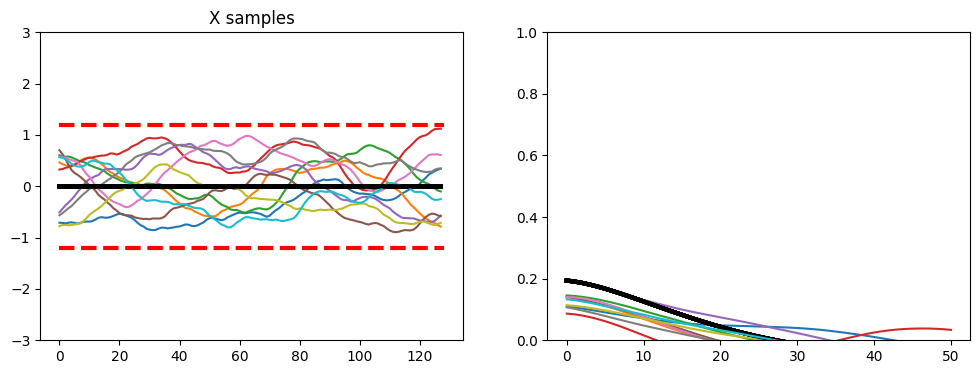

In [4]:
## Prepare training dataset
bound_value = 1.2
ub_value = bound_value
lb_value= -bound_value

GP_1C = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device=device, dims=dims)
x_train = reject_resample(dims, GP_1C, lb_value, ub_value, train_samples)

#x_train = GP_1C.sample_from_prior(dims=dims, n_samples=train_samples)

loader_tr = DataLoader(x_train, batch_size=batch_size, shuffle=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_train.mean(dim=0).squeeze()
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,0,:].numpy(), nlag=50)) for i in range(train_samples)]).mean(dim=0)
#train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

print(x_train.shape)
for i in range(10):
    x = x_train[i,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
ax[0].plot([0, n_x], [bound_value, bound_value],c='r', ls='--', lw=3)
ax[0].plot([0, n_x], [-bound_value, -bound_value],c='r', ls='--', lw=3)
plt.show()

In [5]:
for i in range(N):

    model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=1, t_scaling=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)
    fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)
    fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(500), generate=False, save_path=spath,saved_model=saved_model)


tr @ epoch 1/500 | Loss 0.523695 | 9.48 (s)
tr @ epoch 2/500 | Loss 0.203366 | 9.02 (s)
tr @ epoch 3/500 | Loss 0.161026 | 9.03 (s)
tr @ epoch 4/500 | Loss 0.142997 | 9.03 (s)
tr @ epoch 5/500 | Loss 0.130708 | 9.02 (s)
tr @ epoch 6/500 | Loss 0.125703 | 9.05 (s)
tr @ epoch 7/500 | Loss 0.121578 | 8.97 (s)
tr @ epoch 8/500 | Loss 0.120074 | 8.97 (s)
tr @ epoch 9/500 | Loss 0.118902 | 8.89 (s)
tr @ epoch 10/500 | Loss 0.119788 | 8.96 (s)
tr @ epoch 11/500 | Loss 0.117500 | 8.94 (s)
tr @ epoch 12/500 | Loss 0.115732 | 8.95 (s)
tr @ epoch 13/500 | Loss 0.117716 | 9.00 (s)
tr @ epoch 14/500 | Loss 0.117625 | 8.97 (s)
tr @ epoch 15/500 | Loss 0.115475 | 9.01 (s)
tr @ epoch 16/500 | Loss 0.115178 | 9.03 (s)
tr @ epoch 17/500 | Loss 0.120195 | 9.01 (s)
tr @ epoch 18/500 | Loss 0.118757 | 9.01 (s)
tr @ epoch 19/500 | Loss 0.113816 | 8.99 (s)
tr @ epoch 20/500 | Loss 0.113434 | 8.97 (s)
tr @ epoch 21/500 | Loss 0.113861 | 9.03 (s)
tr @ epoch 22/500 | Loss 0.113076 | 8.98 (s)
tr @ epoch 23/500 |

tr @ epoch 182/500 | Loss 0.110403 | 8.95 (s)
tr @ epoch 183/500 | Loss 0.109903 | 8.97 (s)
tr @ epoch 184/500 | Loss 0.107932 | 9.00 (s)
tr @ epoch 185/500 | Loss 0.108667 | 8.99 (s)
tr @ epoch 186/500 | Loss 0.109851 | 8.99 (s)
tr @ epoch 187/500 | Loss 0.109427 | 9.01 (s)
tr @ epoch 188/500 | Loss 0.110066 | 9.66 (s)
tr @ epoch 189/500 | Loss 0.110392 | 9.07 (s)
tr @ epoch 190/500 | Loss 0.108843 | 9.03 (s)
tr @ epoch 191/500 | Loss 0.108424 | 9.08 (s)
tr @ epoch 192/500 | Loss 0.110043 | 9.14 (s)
tr @ epoch 193/500 | Loss 0.109219 | 9.08 (s)
tr @ epoch 194/500 | Loss 0.107889 | 9.08 (s)
tr @ epoch 195/500 | Loss 0.111267 | 9.07 (s)
tr @ epoch 196/500 | Loss 0.110035 | 9.05 (s)
tr @ epoch 197/500 | Loss 0.108695 | 9.06 (s)
tr @ epoch 198/500 | Loss 0.109623 | 9.06 (s)
tr @ epoch 199/500 | Loss 0.110849 | 9.03 (s)
tr @ epoch 200/500 | Loss 0.109060 | 9.02 (s)
tr @ epoch 201/500 | Loss 0.110268 | 9.02 (s)
tr @ epoch 202/500 | Loss 0.110714 | 9.03 (s)
tr @ epoch 203/500 | Loss 0.110374

tr @ epoch 361/500 | Loss 0.110961 | 9.04 (s)
tr @ epoch 362/500 | Loss 0.108428 | 9.03 (s)
tr @ epoch 363/500 | Loss 0.108444 | 9.08 (s)
tr @ epoch 364/500 | Loss 0.110678 | 9.02 (s)
tr @ epoch 365/500 | Loss 0.109543 | 9.05 (s)
tr @ epoch 366/500 | Loss 0.107791 | 9.06 (s)
tr @ epoch 367/500 | Loss 0.110362 | 9.05 (s)
tr @ epoch 368/500 | Loss 0.110331 | 9.03 (s)
tr @ epoch 369/500 | Loss 0.107944 | 9.06 (s)
tr @ epoch 370/500 | Loss 0.108150 | 9.06 (s)
tr @ epoch 371/500 | Loss 0.108646 | 9.04 (s)
tr @ epoch 372/500 | Loss 0.109174 | 9.05 (s)
tr @ epoch 373/500 | Loss 0.107815 | 9.05 (s)
tr @ epoch 374/500 | Loss 0.110103 | 9.03 (s)
tr @ epoch 375/500 | Loss 0.109683 | 9.04 (s)
tr @ epoch 376/500 | Loss 0.109812 | 9.05 (s)
tr @ epoch 377/500 | Loss 0.108753 | 8.95 (s)
tr @ epoch 378/500 | Loss 0.109897 | 9.04 (s)
tr @ epoch 379/500 | Loss 0.109208 | 9.05 (s)
tr @ epoch 380/500 | Loss 0.108422 | 9.03 (s)
tr @ epoch 381/500 | Loss 0.109648 | 9.02 (s)
tr @ epoch 382/500 | Loss 0.109453

## load trained model

In [5]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=1, t_scaling=1).to(device)
    
for param in model.parameters():
    param.requires_grad = False
        
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [6]:
paper_folder = 'TGP'

if not os.path.exists(f"../Generation_results/{paper_folder}"):
    os.makedirs(f"../Generation_results/{paper_folder}")

In [7]:
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

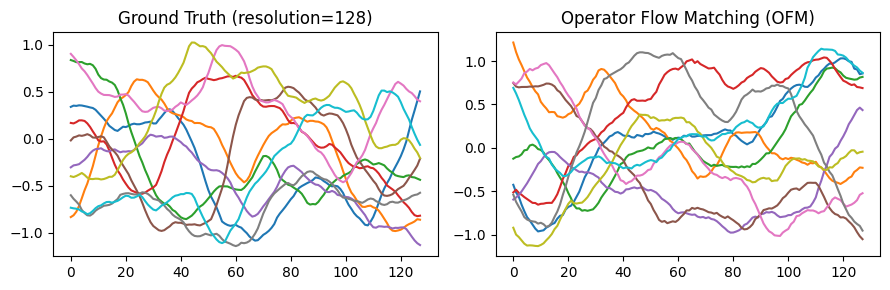

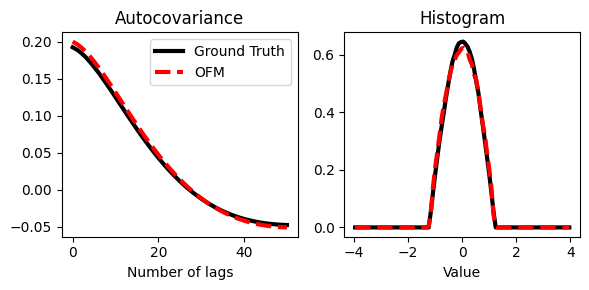

In [8]:
with torch.no_grad():
    X_hat = fmot.sample([n_x], n_samples=10, n_eval=10).cpu().squeeze()
    X_ground_truth = x_train[:10].squeeze()
    # plot
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x], n_samples=1000, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)    
    for i in range(10):
        x = X_hat[i,:]
        x_ground_truth = X_ground_truth[i,:]
        ax[0].plot(x_ground_truth)
        ax[0].set_title('Ground Truth (resolution={})'.format(n_x))
        ax[1].plot(x)
        ax[1].set_title('Operator Flow Matching (OFM)')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
    plt.tight_layout()
    plt.savefig(f"../Generation_results/{paper_folder}/TGP_samples.pdf")
    
    x_mean = X_alt.mean(dim=0)
    x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i, :], nlag=50)) for i in range(3000)]).mean(dim=0)
    
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    ax[0].plot(x_acovf_true, c='k', lw=3, label='Ground Truth')
    ax[0].plot(x_acovf, c='r',ls='--', lw=3, label='OFM')
    #ax[1].set_ylim([0,0.5])
    ax[0].set_xlabel('Number of lags')
    ax[0].set_title('Autocovariance')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3)
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3)
    ax[1].set_title('Histogram')
    ax[1].set_xlabel('Value')
    ax[0].legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"../Generation_results/{paper_folder}/TGP_stat.pdf")

## super-resolution

In [12]:
#n_x_sup_all = [256, 512]
#nlag_sup_all = [100, 200]

n_x_sup = 512
nlag_sup = 200

In [15]:
train_samples_sup = 3000
GP_1C_sup = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device=device, dims=[n_x_sup])
#x_train_sup = GP_1C_sup.sample_from_prior(dims=[n_x*2], n_samples=train_samples_sup)
x_train_sup = reject_resample([n_x_sup], GP_1C_sup, lb_value, ub_value, train_samples_sup)

x_hist_true_sup, bin_edges = x_train_sup.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x_sup)
x_mean_true_sup = x_train_sup.mean(dim=0).squeeze()
x_acovf_true_sup = torch.stack([torch.tensor(sm.tsa.acovf(x_train_sup[i,0,:].numpy(), nlag=nlag_sup)) for i in range(train_samples_sup)]).mean(dim=0)


y_sample.shape:torch.Size([3000, 1, 512])
y_sample.shape:torch.Size([3000, 1, 512])
y_sample.shape:torch.Size([3000, 1, 512])
y_sample.shape:torch.Size([3000, 1, 512])
y_sample.shape:torch.Size([3000, 1, 512])


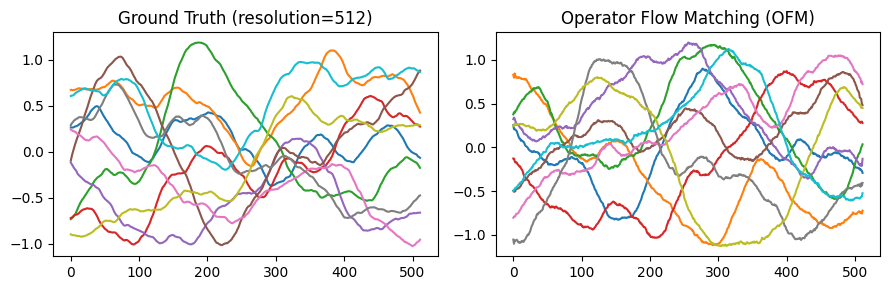

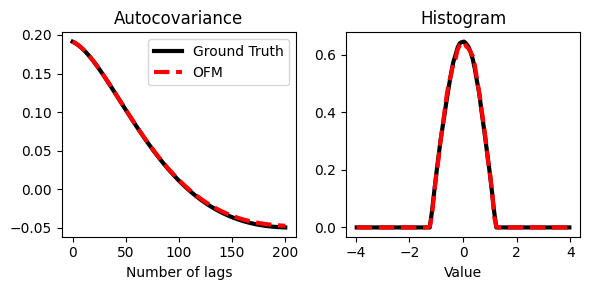

In [16]:
with torch.no_grad():
    X_hat = fmot.sample([n_x_sup], n_samples=10, n_eval=10).cpu().squeeze()
    X_ground_truth = x_train_sup[:10].squeeze()

    fig, ax = plt.subplots(1,2, figsize=(9,3))    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x_sup], n_samples=1000, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)    
    for i in range(10):
        x = X_hat[i,:]
        x_ground_truth = X_ground_truth[i,:]
        ax[0].plot(x_ground_truth)
        ax[0].set_title('Ground Truth (resolution={})'.format(n_x_sup))
        ax[1].plot(x)
        ax[1].set_title('Operator Flow Matching (OFM)')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
    plt.tight_layout()
    plt.savefig(f"../Regression_results/{paper_path}/TGP_samples_sup_{n_x_sup}.pdf")
    
    x_mean = X_alt.mean(dim=0)
    x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i, :], nlag=nlag_sup)) for i in range(3000)]).mean(dim=0)
    
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    ax[0].plot(x_acovf_true_sup, c='k', lw=3, label='Ground Truth')
    ax[0].plot(x_acovf, c='r',ls='--', lw=3, label='OFM')
    #ax[1].set_ylim([0,0.5])
    ax[0].set_xlabel('Number of lags')
    ax[0].set_title('Autocovariance')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3)
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3)
    ax[1].set_title('Histogram')
    ax[1].set_xlabel('Value')
    ax[0].legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"../Regression_results/{paper_path}/TGP_stat_sup_{n_x_sup}.pdf")